# Accessing CMIP6 output with `intake`

---

## Overview
A large swath of CMIP6 output is hosted by the [AWS Open Data Sponsorship Program](https://aws.amazon.com/opendata/public-datasets/) and by Google as part of [Google Cloud Public Datasets](https://cloud.google.com/public-datasets). This notebook will demonstrate how to access, query and request data of interest from a particular source's CMIP6 holdings using [intake](https://github.com/intake/intake-esm). Additionally, we will look at how to concatenate output that may not be on the same calendar.

1. Browse the CMIP6 catalog
1. Select CMIP6 output of interest
1. Concatenate experiments in time (including converting calendars when required)

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| Xarray | Helpful | |
| CMIP6 | Helpful |Familiarity with metadata structure |

- **Time to learn**: 15 min


---

## Imports

In [1]:
from collections import defaultdict, Counter

import pandas as pd
import numpy as np

import intake
import xarray as xr
import nc_time_axis
import pyleoclim as pyleo
import cftime

## CMIP6 Catalog

It's worth taking a minute to explore the catalog and how it's organized. Never fear, opening the datastore doesn't load all holdings into memory, which is good because at the time of writing this there were over 520k files available. 

In [2]:
# for Google Cloud:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# for AWS S3:
# col = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


Alternatively, we could look at the catalog as a pandas dataframe.  While `intake` isn't setup to allow you to pick and choose which datasets you load by filtering the dataframe, the form factor can still be useful for arriving at search criteria.

In [3]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


We can quickly print a list of the values associated with `experiment_id` (or any other column). Nothing ground breaking, but handy when you want to quickly see what experiment output is available. 

In [4]:
# sample of experiments
print('number of experiments: {}'.format(len(col.df.experiment_id.unique())))
col.df.experiment_id.unique()[:20]

number of experiments: 170


array(['highresSST-present', 'piControl', 'control-1950', 'hist-1950',
       'historical', 'amip', 'abrupt-4xCO2', 'abrupt-2xCO2',
       'abrupt-0p5xCO2', '1pctCO2', 'ssp585', 'esm-piControl', 'esm-hist',
       'hist-piAer', 'histSST-1950HC', 'ssp245', 'hist-1950HC', 'histSST',
       'piClim-2xVOC', 'piClim-2xNOx'], dtype=object)

### Identifying potential data of interest
It can be useful to do some rearranging to see how many files are available for each of the most commonly reported variables for each experiment (labeled for convenience by institution and source).

In [5]:
experiments = ['historical', 'past1000', 'midHolocene', 'hist-volc','lgm']
experiment_subset = col.df[col.df.experiment_id.isin(experiments)]

In [6]:
sources = [grp[0] for grp in experiment_subset.groupby('source_id') if len(grp[1].experiment_id.unique())>2]

In [7]:
source_sub = experiment_subset[experiment_subset.source_id.isin(sources)]

In [8]:
table = pd.pivot_table(experiment_subset[experiment_subset.source_id.isin(sources)],
                       values='member_id', index=['institution_id','experiment_id','source_id'],
                       columns=['variable_id'], aggfunc='count')

table = table.dropna(axis='columns', thresh=int(.65*len(table))).fillna(value=0)
pd.concat([table, table.aggregate('sum', axis="columns").rename('total')], axis=1)


pr    ta   tas    ua  total
institution_id experiment_id source_id                                    
AWI            historical    AWI-ESM-1-1-LR   2.0   3.0   3.0   5.0   13.0
               lgm           AWI-ESM-1-1-LR   1.0   1.0   1.0   0.0    3.0
               midHolocene   AWI-ESM-1-1-LR   0.0   1.0   0.0   1.0    2.0
INM            historical    INM-CM4-8        2.0   2.0   2.0   3.0    9.0
               lgm           INM-CM4-8        1.0   0.0   1.0   0.0    2.0
               midHolocene   INM-CM4-8        0.0   1.0   0.0   1.0    2.0
MIROC          historical    MIROC-ES2L      41.0  31.0  42.0  33.0  147.0
               lgm           MIROC-ES2L       1.0   1.0   1.0   1.0    4.0
               past1000      MIROC-ES2L       1.0   1.0   0.0   0.0    2.0
MPI-M          historical    MPI-ESM1-2-LR   20.0  23.0  30.0  28.0  101.0
               lgm           MPI-ESM1-2-LR    1.0   1.0   1.0   1.0    4.0
               midHolocene   MPI-ESM1-2-LR    0.0   1.0   0.0   1.0    2.0
MRI            hist-volc     MRI-ESM2-0       0.0   0.0   0.0   0.0    0.0
               historical    MRI-ESM2-0      23.0  17.0  18.0  21.0   79.0
               midHolocene   MRI-ESM2-0       0.0   1.0   0.0   1.0    2.0
               past1000      MRI-ESM2-0       1.0   1.0   1.0   0.0    3.0

### Pulling data

#### Forming a query dictionary
From here we need to write a dictionary with information `intake` can use to filter the collection. Sometimes hard coding the dictionary by copying and pasting particular values, is the most efficient way to go, but below it is assembled based on the sources and experiments used to filter above, and the variables most commonly reported.

In [9]:
table.columns.values

array(['pr', 'ta', 'tas', 'ua'], dtype=object)

In [10]:
query_d = dict(source_id=sources, 
     experiment_id=experiments, 
     grid_label='gn', 
     variable_id=table.columns.values.tolist(), 
     table_id='Amon'
    )

In [11]:
 search_res = col.search(**query_d)

Additionally, there is at least one, but often multiple members. For our purposes, it would be best to have the same member configurations across experiments so let's identify which members are common and refine our query accordingly

In [12]:
members = list(set([grp[0][2] for grp in search_res.df.groupby(['source_id', 'variable_id', 'member_id']) 
 if len(grp[1].experiment_id.unique())>1]))

In [13]:
query_d['member_id'] = members

In [14]:
search_res = col.search(**query_d)

#### Requesting from the cloud

In [16]:
# sometimes you have to run this cell twice
_esm_data_d = search_res.to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})
_esm_data_d.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['PMIP.MIROC.MIROC-ES2L.past1000.Amon.gn', 'PMIP.AWI.AWI-ESM-1-1-LR.lgm.Amon.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn', 'PMIP.MPI-M.MPI-ESM1-2-LR.lgm.Amon.gn', 'PMIP.MRI.MRI-ESM2-0.past1000.Amon.gn', 'PMIP.MIROC.MIROC-ES2L.lgm.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Amon.gn'])

The returned dictionary has one level. Let's rearrange a bit so that the `institution_id` is top level, then the `source_id`, and then the `experiment_id`. This will make it a bit easier to grab experiments from the same source. 

In [17]:
esm_data_d = {}
for key in _esm_data_d.keys():
    parts = key.split('.', 4)
    if parts[1] not in esm_data_d.keys():
        esm_data_d[parts[1]]= defaultdict(dict)
    esm_data_d[parts[1]][parts[2]][parts[3]] = _esm_data_d[key]

In [18]:
for key in esm_data_d.keys():
    print(key)
    for key2 in esm_data_d[key].keys():
        if type(esm_data_d[key][key2])==dict:
            print('\t{}: {}'.format(key2, esm_data_d[key][key2].keys()))
        

MIROC
	MIROC-ES2L: dict_keys(['past1000', 'lgm', 'historical'])
AWI
	AWI-ESM-1-1-LR: dict_keys(['lgm', 'historical'])
MPI-M
	MPI-ESM1-2-LR: dict_keys(['historical', 'lgm'])
MRI
	MRI-ESM2-0: dict_keys(['past1000', 'historical'])


## Making a single time series
Let's concatenate the `past1000` and `historical` output into a single timeseries.

In [19]:
exp_list= [esm_data_d['MRI']['MRI-ESM2-0'][key] for key in ['past1000', 'historical']]

In [20]:
_ds = xr.concat(exp_list, dim='time')
_ds

<xarray.Dataset>
Dimensions:         (lat: 160, bnds: 2, lon: 320, member_id: 1,
                     dcpp_init_year: 1, time: 13980, plev: 19)
Coordinates:
  * lat             (lat) float64 -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
    lat_bnds        (lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 88.59 90.0
  * lon             (lon) float64 0.0 1.125 2.25 3.375 ... 356.6 357.8 358.9
    lon_bnds        (lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 359.4
  * time            (time) object 0850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(12000, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * plev            (plev) float64 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
    height          float64 2.0
Dimensions without coordinates: bnds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 308, 160, 320), meta=np.ndarray>
    ta              (member_id, dcpp_init_year, time, plev, lat, lon) float32 dask.array<chunksize=(1, 1, 26, 19, 160, 320), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 439, 160, 320), meta=np.ndarray>
    ua              (member_id, dcpp_init_year, time, plev, lat, lon) float32 dask.array<chunksize=(1, 1, 35, 19, 160, 320), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      PMIP
    branch_method:                    no parent
    cmor_version:                     3.5.0
    data_specs_version:               01.00.31
    experiment:                       last millennium
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20200120
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           PMIP.MRI.MRI-ESM2-0.past1000.Amon.gn

In order to visualize the timeseries we just carefully assembled, we need to focus in on a specific location (we'll save the production of an animation showing the time evolution of a spatial distribution for a future notebook). In the cell below, we'll specify a dictionary containing a `lat`, `lon` pair. By using the coordinate names used for latitude and longitude in the xarray dataset, we can select from the dataset simply by passing the dictionary. 

Let's focus in on -10N, 110E, which happens to be a location downwind of Tambora, a volcano in Indonesia that erupted enthusiastically in 1816.   

In [21]:
lat, lon = -10, 110

In [22]:
loc = {'lat':lat, 'lon':lon}
da = _ds.sel(loc,  method="nearest")['tas']

Notice that `method` is set to `"nearest"`. It's useful that Xarray will return the nearest data to the search criteria. Other options include: `None, "nearest", "pad", "ffill", "backfill", "bfill"`. Details about what these options entail can be found in the [xarray documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html).

Looking into the details of the returned DataArray, we can see that the nearest location was -9.533N, 110.2E. Very near, indeed.  

In [23]:
da

<xarray.DataArray 'tas' (member_id: 1, dcpp_init_year: 1, time: 13980)>
dask.array<getitem, shape=(1, 1, 13980), dtype=float32, chunksize=(1, 1, 600), chunktype=numpy.ndarray>
Coordinates:
    lat             float64 -9.533
    lon             float64 110.2
  * time            (time) object 0850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 2.0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2020-01-04T03:36:44Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    original_name:  TA
    standard_name:  air_temperature
    units:          K

In order to build a Pyleoclim `Series`, we need to convert the time units into fractional years. To do this, we'll use a package called `cftime` that has a slurry of methods to help convert between different descriptions of time. In the cell below, let's write a short function that converts the time coordinate of a DataArray first to `'days since 00-01-01'` (specifying that `has_year_zero`=`True`) and then fractional years by dividing by 365 (assuming no leap year).

In [24]:
def time_to_float(da):
    float_time = [cftime.date2num(da.time.data[ik],
                              units='days since 00-01-01',
                              calendar='noleap', 
                              has_year_zero=True)/365 
              for ik in range(len(da.time))]
    return float_time

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'MRI-ESM2-0; lat: -10N, lon: 110E'}, xlabel='year', ylabel='Surface Air Temp (K)'>)

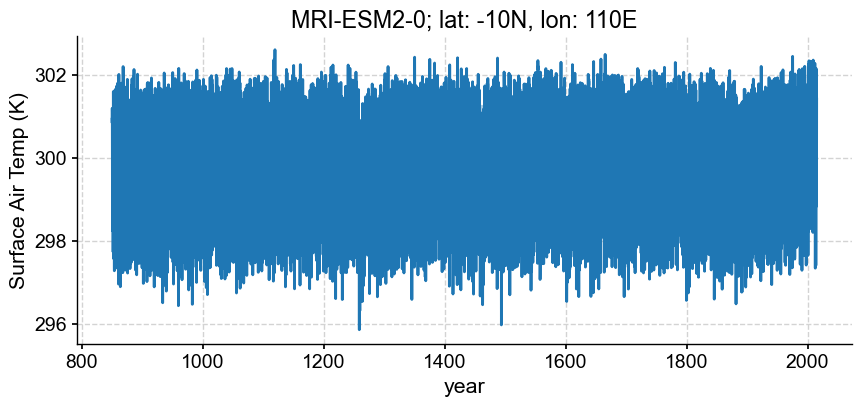

In [25]:
%time
model ='MRI-ESM2-0'
ts = pyleo.Series(time=time_to_float(da), value=da.squeeze().data, 
                  time_unit='years', clean_ts=False, 
                  value_name='Surface Air Temp (K)',
                  verbose=False)
ts.plot(xlabel='year', 
        title='{}; lat: {}N, lon: {}E'.format(model, loc['lat'], loc['lon']))

### Converting Calendars

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
 Experiments do not necessarily fall on the same calendar, even those carried out using the same model. 
</div>

If two different datasets do not use the same calendar, it will be difficult to use the concatenated data. For example, `past1000` is of type `cftime.DatetimeProlepticGregorian` while `historical` is of type `cftime.DatetimeGregorian`, despite both being produced with MIROC-ES2L.

In [26]:
exp_list= [esm_data_d['MIROC']['MIROC-ES2L'][key] for key in ['past1000', 'historical']]

In [27]:
exp_list[0].time[0].data, exp_list[1].time[0].data

(array(cftime.DatetimeProlepticGregorian(850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       dtype=object),
 array(cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       dtype=object))

However, xarray can help! If we pass a target calendar (e.g. 'proleptic_gregorian') to `convert_calendar()` (a method attached to our dataset), xarray will do its best to make the conversion. Note: specify `use_cftime=True` if you prefer time to be of type `cftime` as xarray returns in type `datetime64[ns]` by default.

In [28]:
exp_list[1] = exp_list[1].convert_calendar('proleptic_gregorian', 
                                           use_cftime=True)

In [29]:
exp_list[0].time[0].data, exp_list[1].time[0].data

(array(cftime.DatetimeProlepticGregorian(850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       dtype=object),
 array(cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       dtype=object))

In [30]:
_ds = xr.concat(exp_list, dim='time')

In [31]:
loc['plev']=100000
da = _ds.sel(loc,  method="nearest")['ta']

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'MIROC-ES2L; lat: -10N, lon: 110E'}, xlabel='year', ylabel='Air Temp (K) at 1000hPa'>)

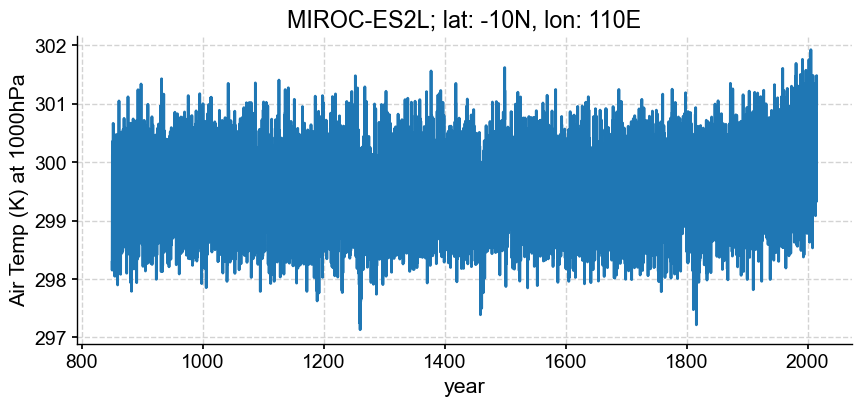

In [32]:
model ='MIROC-ES2L'
ts = pyleo.Series(time_to_float(da), da.squeeze().data, 
                  time_unit='years', clean_ts=False, 
                  value_name='Air Temp (K) at 1000hPa',
                  verbose=False)
ts.plot(xlabel='year', 
        title='{}; lat: {}N, lon: {}E'.format(model, loc['lat'], loc['lon']))

Below, the two experiments are visualized together without trouble, so by no means is it always necessary to formally convert calendars and concatenate. However it can be convenient for resampling, or other subsequent data processing.

In [ ]:
loc = {'lat':lat, 'lon':lon, 'plev':100000}
model ='MIROC-ES2L'
segs = []
for key in ['past1000', 'historical']:
    da = esm_data_d['MIROC']['MIROC-ES2L'][key].sel(loc,  method="nearest")['ta']
    segs.append(pyleo.Series(time_to_float(da), da.squeeze().data, 
                             time_unit='years', 
                             clean_ts=False,
                             value_name='Air Temp (K) at 1000hPa', 
                             label = '_'.join([model, key]),
                             verbose=False))

In [ ]:
ax = segs[0].plot(xlabel='year', title='{}; lat: {}N, lon: {}E'.format(model, loc['lat'], loc['lon']))
segs[1].plot(ax = ax[1], xlabel='year', title='{}; lat: {}N, lon: {}E'.format(model, loc['lat'], loc['lon']))


---

## Summary
Accessing CMIP6 data via intake takes a little getting used to, but is a very efficient strategy for leveraging a mammoth body of data without having to store it locally. Working with output from different sources/experiments comes with processing overhead like aligning calendars, but the community (particularly xarray) is rich with strategies for smoothing these wrinkles. 

## What's next?
Check out our science bit about [CMIP6 and LMR](../science_bits/CMIP6_LMR.ipynb) to see how to compare CMIP6 model output to climate reconstructions!

## Resources and references

| _For details, see_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|